Loading Data

In [0]:
# config
storage_account = "lab94290"  
container = "airbnb"

sas_token="sp=rle&st=2025-12-24T17:37:04Z&se=2026-02-28T01:52:04Z&spr=https&sv=2024-11-04&sr=c&sig=a0lx%2BS6PuS%2FvJ9Tbt4NKdCJHLE9d1Y1D6vpE1WKFQtk%3D"
sas_token = sas_token.lstrip('?')
spark.conf.set(f"fs.azure.account.auth.type.{storage_account}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{storage_account}.dfs.core.windows.net", sas_token)

In [0]:
path = f"abfss://{container}@{storage_account}.dfs.core.windows.net/airbnb_1_12_parquet"

In [0]:
airbnb_df = spark.read.parquet(path)


In [0]:
dbutils.fs.cp(
  "file:/Workspace/Users/sham.alem@campus.technion.ac.il/Italy_DataSet.csv",
  "dbfs:/FileStore/Italy_DataSet.csv"
)

dbutils.fs.cp(
  "file:/Workspace/Users/sham.alem@campus.technion.ac.il/Germany_DataSet.csv",
  "dbfs:/FileStore/Germany_DataSet.csv"
)

dbutils.fs.cp(
  "file:/Workspace/Users/sham.alem@campus.technion.ac.il/France_DataSet.csv",
  "dbfs:/FileStore/France_DataSet.csv"
)


True

In [0]:
df_italy = spark.read.option("header", True).option("inferSchema", True) \
    .csv("dbfs:/FileStore/Italy_DataSet.csv")

df_germany = spark.read.option("header", True).option("inferSchema", True) \
    .csv("dbfs:/FileStore/Germany_DataSet.csv")

df_france = spark.read.option("header", True).option("inferSchema", True) \
    .csv("dbfs:/FileStore/France_DataSet.csv")


**Initial Data Preparation and observations**

We transformed the raw OpenStreetMap export into a structured landmark dataset by consolidating tag columns into key–value maps, extracting semantic identifiers, selecting a assigns a single site type using a priority order per landmark, and filtering to valid geolocated points.

In [0]:
from pyspark.sql import functions as F

def extract_clean_landmarks(df_raw, wiki_lang):
    """
    Input: raw OSM export df with ExtendedData/Data/.../_name + /value columns
    Output: clean df with name, lat, lon, wikipedia, wikidata, site_type
    """
    # 1) Build list of (_name, value) column pairs
    name_cols = [c for c in df_raw.columns
                 if c.startswith("ExtendedData/Data/") and c.endswith("/_name")]
    val_cols = [c.replace("/_name", "/value") for c in name_cols]
    pairs = [(n, v) for n, v in zip(name_cols, val_cols) if v in df_raw.columns]

    # 2) Build MAP column "tags"
    entries = []
    for ncol, vcol in pairs:
        k = F.col(f"`{ncol}`").cast("string")
        v = F.col(f"`{vcol}`").cast("string")

        key_ok = k.isNotNull() & (F.trim(k) != "")
        val_ok = v.isNotNull() & (F.trim(v) != "")

        entries.append(F.when(key_ok & val_ok, F.struct(k.alias("key"), v.alias("value"))))

    empty_arr = F.array().cast("array<struct<key:string,value:string>>")
    tags_map = F.map_from_entries(F.coalesce(F.filter(F.array(*entries), lambda x: x.isNotNull()), empty_arr))
    df1 = df_raw.withColumn("tags", tags_map)

    # helper
    def get_first_from_map(map_col, keys):
        return F.coalesce(*[F.element_at(map_col, F.lit(k)) for k in keys])

    # 3) Extract fields
    df2 = df1.select(
        F.col("name").alias("name"),
        F.col("latitude").cast("double").alias("lat"),
        F.col("longitude").cast("double").alias("lon"),
        get_first_from_map(F.col("tags"), ["wikipedia", "wikipedia:en", f"wikipedia:{wiki_lang}"]).alias("wikipedia"),
        get_first_from_map(F.col("tags"), ["wikidata"]).alias("wikidata"),
        get_first_from_map(F.col("tags"), ["tourism"]).alias("tourism"),
        get_first_from_map(F.col("tags"), ["historic"]).alias("historic"),
        get_first_from_map(F.col("tags"), ["amenity"]).alias("amenity"),
        get_first_from_map(F.col("tags"), ["man_made"]).alias("man_made"),
    )

    # 4) Replace 'yes' with NULL
    df2_clean = (
        df2
        .withColumn("historic",  F.when(F.lower(F.col("historic"))  == "yes", None).otherwise(F.col("historic")))
        .withColumn("amenity",   F.when(F.lower(F.col("amenity"))   == "yes", None).otherwise(F.col("amenity")))
        .withColumn("man_made",  F.when(F.lower(F.col("man_made"))  == "yes", None).otherwise(F.col("man_made")))
        .withColumn("tourism",   F.when(F.lower(F.col("tourism"))   == "yes", None).otherwise(F.col("tourism")))
    )

    # 5) site_type priority
    df3 = df2_clean.withColumn("site_type", F.coalesce("historic", "amenity", "man_made", "tourism"))

    # 6) final clean
    clean_df = (
        df3.select("name", "lat", "lon", "wikipedia", "site_type", "wikidata")
           .where(F.col("name").isNotNull() & (F.trim(F.col("name")) != ""))
           .where(F.col("lat").isNotNull() & F.col("lon").isNotNull())
    )
    clean_df = clean_df.where(F.col("site_type").isNotNull())
    return clean_df


filter_by_bbox
This function filters the dataset to keep only landmarks whose latitude and longitude fall within a specified geographic bounding box, ensuring that only points located inside the target country or region are retained.


In [0]:
def filter_by_bbox(df, lat_min, lat_max, lon_min, lon_max):
    return (df
            .filter(F.col("lat").between(lat_min, lat_max))
            .filter(F.col("lon").between(lon_min, lon_max)))


This function standardizes the raw `site_type` values and maps them into a smaller set of **high-level landmark categories**.
It first normalizes the text (lowercasing, trimming, fixing spelling variants), then groups many detailed OSM tags (e.g., *church, castle, museum, ruins*) into broader, human-interpretable classes such as **religious**, **historic_building**, **culture_education**, or **tourism**....
The result is a single `site_type_general` column that makes landmarks easier to analyze, deduplicate, and use in recommendations.


In [0]:
from pyspark.sql import functions as F

def add_site_type_general(df):
    df = df.withColumn("site_type_norm", F.lower(F.trim(F.col("site_type"))))
    df = df.withColumn("site_type_norm", F.regexp_replace("site_type_norm", r"\s+", "_"))
    df = df.withColumn("site_type_norm", F.split(F.col("site_type_norm"), ";").getItem(0))

    # normalize spelling variants
    df = df.withColumn(
        "site_type_norm",
        F.when(F.col("site_type_norm").isin("abbay", "abbaye", "abbey"), "abbey")
         .otherwise(F.col("site_type_norm"))
    )

    df = df.withColumn(
        "site_type_general",
        F.when(F.col("site_type_norm").isin(
            "church","cathedral","chapel","monastery","abbey",
            "place_of_worship","temple",
            "wayside_shrine","wayside_chapel","wayside_cross",
            "place_of_mourning","bell_tower"
        ), "religious")

        .when(F.col("site_type_norm").isin(
            "castle","palace","villa","manor","house",
            "heritage","heritage_building","building",
            "courthouse","townhall","courtyard",
            "architectural_element","garden","warehouse","prison","park","marketplace"
        ), "historic_building")

        .when(F.col("site_type_norm").isin(
            "fort","fortress","fortification","battery",
            "city_gate","citywalls","city_wall","castle_wall",
            "bunker","watchtower","battlefield","tank"
        ), "military_defense")

        .when(F.col("site_type_norm").isin(
            "archaeological_site","ruins","catacomb",
            "tomb","grave_yard","cemetery",
            "roman_road","gallows","pillory",
            "rune_stone","boundary_marker","boundary_stone","stone"
        ), "archaeology_ruins")

        .when(F.col("site_type_norm").isin(
            "monument","memorial","column","obelisk","milestone",
            "survey_point","highwater_mark","meridian_marker","colonnade","clock","cross"
        ), "monument_memorial")

        .when(F.col("site_type_norm").isin(
            "museum","theatre","arts_centre","library",
            "university","college","school","archive",
            "planetarium","observatory",
            "events_venue","conference_centre","festival_grounds","community_centre"
        ), "culture_education")

        .when(F.col("site_type_norm").isin(
            "bridge","tower","communications_tower","water_tower","graduation_tower",
            "aqueduct","lighthouse","pier","dock","lock","tunnel",
            "watermill","windmill","water_wheel",
            "pumping_station","water_works","works","industrial","crane","chimney","silo","gasometer",
            "fountain","lavoir","drinking_water","water_well","spring_box","reservoir_covered",
            "quarry","mine","mineshaft","adit","spoil_heap",
            "optical_telegraph","beacon"
        ), "infrastructure_utility")

        .when(F.col("site_type_norm").isin(
            "restaurant","cafe","pub","biergarten","casino",
            "hospital","pharmacy","police","public_bath",
            "social_facility","animal_shelter","science","food_court"
        ), "services")

        .when(F.col("site_type_norm").isin(
            "ship","submarine","vessel","aircraft","locomotive",
            "rocket","cannon","wreck","exhibit","technical_monument"
        ), "objects_exhibits")

        .when(F.col("site_type_norm").isin(
            "attraction","unesco_world_heritage"
        ), "tourism")

        .otherwise("other")
    )

    # drop helper col
    return df.drop("site_type_norm")


This function removes **local duplicates** of landmarks by keeping only one row for each *(wikidata, name)* **within the same geographic area**, defined by a spatial grid. It first normalizes the name and assigns each point to a latitude–longitude grid cell (about 5 km in size), then uses a window function to keep only one landmark per cell. Importantly, landmarks with the same name and Wikidata that are **far apart** fall into different grid cells and are therefore preserved, while rows without Wikidata are kept unchanged.


In [0]:
from pyspark.sql import functions as F, Window

def dedup_by_name_wikidata_with_grid(df, grid=0.05):
    """
    Keep 1 row per (wikidata, name) within each spatial grid cell (~grid degrees).
    This prevents deleting far-apart points that share the same name+wikidata.
    
    If wikidata is NULL -> keep all rows (no reliable identity).
    """
    df2 = (df
        .withColumn("name_norm", F.lower(F.trim(F.col("name"))))
        .withColumn("lat_cell", F.floor(F.col("lat") / F.lit(grid)))
        .withColumn("lon_cell", F.floor(F.col("lon") / F.lit(grid)))
    )

    w = Window.partitionBy("wikidata", "name_norm", "lat_cell", "lon_cell").orderBy(F.lit(1))

    out = (df2
        .withColumn("rn", F.row_number().over(w))
        .where(F.col("wikidata").isNull() | (F.col("rn") == 1))
        .drop("rn", "name_norm", "lat_cell", "lon_cell")
    )
    return out


This cell first converts the raw OpenStreetMap exports for France, Italy, and Germany into clean landmark datasets with standardized fields and valid geographic coordinates.
It then filters each dataset to keep only landmarks located within the geographic boundaries of the corresponding country using bounding boxes.
Finally, it removes duplicate landmarks by keeping a single representative entry for each real-world place, collapsing records that share the same identity or that are very close geographically and have the same name and type.


In [0]:
# Base cleaning
clean_france  = extract_clean_landmarks(df_france,  wiki_lang="fr")
clean_italy   = extract_clean_landmarks(df_italy,   wiki_lang="it")
clean_germany = extract_clean_landmarks(df_germany, wiki_lang="de")

# Geo filter (bbox)
clean_france_geo  = filter_by_bbox(clean_france,  41.0, 51.5, -5.5,  9.8)
clean_italy_geo   = filter_by_bbox(clean_italy,   35.0, 47.5,  6.0, 19.0)
clean_germany_geo = filter_by_bbox(clean_germany, 47.2, 55.2,  5.5, 15.6)

#duplicates cleaning 
clean_france_dedup  = dedup_by_name_wikidata_with_grid(clean_france_geo,  grid=0.05)
clean_italy_dedup   = dedup_by_name_wikidata_with_grid(clean_italy_geo,   grid=0.05)
clean_germany_dedup = dedup_by_name_wikidata_with_grid(clean_germany_geo, grid=0.05)



the info about wikipedia and wikidata are no longer needed, so we drop them : 

In [0]:
# Drop wikipedia and wikidata columns after dedup
clean_france_dedup  = clean_france_dedup.drop("wikipedia", "wikidata")
clean_italy_dedup   = clean_italy_dedup.drop("wikipedia", "wikidata")
clean_germany_dedup = clean_germany_dedup.drop("wikipedia", "wikidata")


This cell maps each cleaned and deduplicated landmark to a broad, standardized category and displays the final landmark datasets for France, Italy, and Germany.


In [0]:

clean_france_final  = add_site_type_general(clean_france_dedup)
clean_italy_final   = add_site_type_general(clean_italy_dedup)
clean_germany_final = add_site_type_general(clean_germany_dedup)
display(clean_france_final.limit(30))
display(clean_italy_final.limit(30))
display(clean_germany_final.limit(30))


name,lat,lon,site_type,site_type_general
"""Ancienne Abbaye de Saint-Ruf """"le Haut""""""",44.9337924,4.8899085,attraction,tourism
Abbaye de Noirlac,46.745142,2.4615592,monastery,religious
Abbaye du Thoronet,43.4603962,6.263633,abbay,religious
Abîme de Bramabiau,44.1200621,3.4751617,attraction,tourism
Alpina Blitz,48.2617727,4.6149158,attraction,tourism
Amphithéâtre romain de Cahors,44.4454378,1.4406735,archaeological_site,archaeology_ruins
Ancien Garage du Méridien,45.7736112,4.7528002,attraction,tourism
Ancienne Chocolaterie Menier,48.8569385,2.6236891,attraction,tourism
Ancienne faïencerie,50.360581,3.5257107,attraction,tourism
Aqueduc du Gier,45.7264509,4.779617,attraction,tourism


name,lat,lon,site_type,site_type_general
"""Orto Botanico """"Pietro Castelli""""""",38.1924124,15.5461482,attraction,tourism
"""Relitto cargo """"Potho""""""",43.5483887,13.6276214,wreck,objects_exhibits
"""Villa Pisani detta """"La Barbariga""""""",45.4120344,12.0185032,manor,historic_building
Abbazia di Santa Maria del Pero,45.6582208,12.4194056,manor,historic_building
Abbazia Santa Maria in Silvis,45.8485038,12.8162983,place_of_worship,religious
Abitato Etrusco,42.8613132,10.9738187,archaeological_site,archaeology_ruins
Acquedotto di Nepi,42.2440187,12.3444269,aqueduct,infrastructure_utility
Aero Club Como,45.8139103,9.0708163,attraction,tourism
Archaeological site of Hera Argiva,40.488307,14.9699391,attraction,tourism
Area Sacra Foro di Preneste - Antro delle Sorti,41.8394439,12.8921681,archaeological_site,archaeology_ruins


name,lat,lon,site_type,site_type_general
"""Katholische Bildungsstätte """"Bernardusheim""""""",51.0889583,6.5904892,social_facility,services
"""Kelto-römische Kultstätte """"Juddekirchhof""""""",50.2306244,6.6746137,archaeological_site,archaeology_ruins
"""Kettenschleppdampfer """"Gustav Zeuner""""""",52.1488105,11.6618938,ship,objects_exhibits
"""Schaufelrad-Schleppdampfer """"Württemberg""""""",52.1175208,11.6385707,ship,objects_exhibits
"""Seenotrettungskreuzer """"Theodor Heuss""""""",48.1290562,11.5817238,ship,objects_exhibits
"""Wrack Schlepper """"Hedwig""""""",52.3245202,14.1617268,wreck,objects_exhibits
1000-jährige Eiche,52.9355672,8.3806835,attraction,tourism
1000-jährige Linde,52.0811546,13.1668668,attraction,tourism
A300 ZERO-G,50.8824003,7.1149767,aircraft,objects_exhibits
Aalschokker,49.7557028,8.4784652,ship,objects_exhibits


In [0]:
def print_country_row_counts(france_df, italy_df, germany_df):
    print(f"France landmark rows:  {france_df.count()}")
    print(f"Italy landmark rows:   {italy_df.count()}")
    print(f"Germany landmark rows: {germany_df.count()}")
print_country_row_counts(
    clean_france_final,
    clean_italy_final,
    clean_germany_final
)


France landmark rows:  2531
Italy landmark rows:   2816
Germany landmark rows: 4450


This code cleans the Airbnb dataset by removing duplicate listings(same seller id + property id) and rows with missing essential information, and by ensuring prices and amenities are valid.
It then extracts the country from the location field, keeps only listings in France, Italy, and Germany, and converts prices into a common scale using currency information.
Finally, it displays the number of listings per country and the cleaned Airbnb data ready for analysis and enrichment.


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

# 0) Start + drop fully identical rows
airbnb_clean = airbnb_df.dropDuplicates()

# 1) Extract seller_id
airbnb_clean = airbnb_clean.withColumn(
    "seller_id",
    F.get_json_object(F.col("seller_info"), "$.seller_id")
)

# 2) Drop rows missing essentials (based on what we truly need later)
airbnb_clean = airbnb_clean.na.drop(subset=[
    "property_id",
    "seller_id",
    "ratings",
    "property_number_of_reviews",
    "amenities",
    "location",
    "lat",
    "long",
    "is_guest_favorite",
    "is_supperhost",
    "host_number_of_reviews",
    "host_rating",
    "host_response_rate",
    "pets_allowed",
    "description_by_sections",
    "description_html",
    "location_details_html"
])


# 3) Drop empty amenities string
airbnb_clean = airbnb_clean.filter(
    F.col("amenities").isNotNull() & (F.length(F.trim(F.col("amenities"))) > 2)
)

# 4) Add country from location
airbnb_clean = airbnb_clean.withColumn(
    "country",
    F.trim(F.element_at(F.split(F.col("location"), ","), -1))
)

# 5) Filter only France / Italy / Germany
airbnb_eu = airbnb_clean.filter(F.col("country").isin("France", "Italy", "Germany"))


airbnb_eu = airbnb_eu.select(
    "property_id", "seller_id", "country", "lat", "long",
    "ratings", "property_number_of_reviews",
    "description", "description_html", "location_details_html", "description_by_sections",
    "amenities", "pets_allowed",
    "is_supperhost", "is_guest_favorite",
    "host_number_of_reviews", "host_rating", "host_response_rate"
)

display(airbnb_eu.groupBy("country").count().orderBy(F.col("count").desc()))
display(airbnb_eu.limit(50))
print(f"airbnb)eu rows:  {airbnb_eu.count()}")

country,count
France,85117
Italy,40965
Germany,16458


property_id seller_id country lat long ratings property_number_of_reviews description description_html location_details_html description_by_sections amenities pets_allowed is_supperhost is_guest_favorite host_number_of_reviews host_rating host_response_rate 1350347 7327204 Italy 43.32251 11.15581 4.91 86 Charming cottage in the heart of Tuscany on a peaceful property. It is surrounded by a big private garden and has a marvelous panoramic terrace with stunning views over San Gimignano and the Chianti Hills.PRIVACY: EACH APARTMENT HAS A PRIVATE ENTRANCE AND TERRACE FOR TOTAL PRIVACYCLEANING: APARTMENTS ARE DISINFECTED WITH CERTIFIED EQUIPMENT BEFORE EACH ARRIVALPOOL: EACH APARTMENT HAS A DESIGNATED SPACE RESERVED AT THE POOL.SMART SERVICES: WEB CHECK-IN AND GUEST ASSISTANCE VIA SMARTPHONE APPThe spaceLa Capanna is a fabulous apartment in the original Tuscan style, with terracotta floors and wooden beamed ceilings. It forms part of Ripostena Country House, a private ancient hamlet restored according to traditional Tuscan style and equipped with all amenities to make you feel at home.La Capanna and another apartment, Il Fienile, are located in the same house, called Boscobello.La Capanna is surrounded by a big private garden and has a marvelous panoramic terrace, which is covered, completely furnished with table, chairs and bbq and is perfect for outdoor dining and gathering.This two story apartment is 91 square meters (977 square foot), can accommodate up to 6 people and is composed as follows:Two double bedrooms (one of which with ceiling fan) and one bathroom with shower and double sink at the first floor.At the ground floor there is a spacious living and dining area furnished with table, chairs and a comfortable sofa-bed. The kitchen is fully equipped with a stovetop, oven, microwave, dishwasher, refrigerator with freezer, kettle, toaster, and espresso coffee maker with pods.AT THE TOP OF THE STAIRCASE A GATE IS INSTALLED TO ENSURE THE SAFETY OF THE CHILDREN.The apartment is located just in front of the recreation room, just steps away from the children's playground and 2 min. walk from the property’s panoramic stone infinity pool.A free Wi-Fi connection is available for all our guests.Guest accessOur guests share common areas such as: infinity pool overlooking the valley, 5 hectares (12 acres) of colorful and carefully maintained gardens and green areas, picnic area, children’s playground, and recreation room with ping pong and table football.Other things to noteThe pool is shared with other guests. The POOL HOURS are 9 am to 8 pm.The apartment is part of the ancient hamlet of Ripostena, which is private and entirely fenced-in. On the property there are 8 other apartments, all with independent entrance. It is possible to view them all on AirBnB and they are called Casa Bertilla (up to 4 people), La Rimessa (up to 6 people), L’Essiccatoio (up to 5 people), Il Trinciatoio (up to 6 people), Casa Vecchia (up to 6 people), Il Frantoio (up to 4 people), La Capanna (up to 6 people), Il Fienile (up to 4 people) and Boscobello (up to 10 people).If the apartment or dates you want are not available, please contact us and we are happy to check other apartments’ availability.On request, upon availability: baby cot, high chair, extra beds, iron and ironing board and hair dryer.Wi-Fi internet connection and ample free parking available.A laundry room is available for all guests.WHAT’S NOT INCLUDED IN THE PRICE:HEATING, IF USED, WILL BE CALCULATED WITH METER READINGS. THE COST IS 2 EUROS PER HOUR.Extra fee for pet: 30 Euros per stay.For all guests 12 years and older there is mandatory tourist tax of 1 Euro per night per person; for 5 night stays or longer the tax is 5 Euros per person for the total stay.Registration DetailsIT052004B4TRGGTZEL 
 
Charming cottage in the heart of Tuscany on a peaceful property. It is surrounded by a big private garden and has a marvelous panoramic terrace with stunning views over San Gimignano and the Chianti H

airbnb)eu rows:  142540


In [0]:
from pyspark.sql import functions as F

df = airbnb_eu

# ---------- lat / long ----------
df = df.withColumn("lat",  F.col("lat").cast("double")) \
       .withColumn("long", F.col("long").cast("double"))

# ---------- ratings (keep first number like 4.83 from "4.83/5" etc.) ----------
df = df.withColumn(
    "ratings",
    F.regexp_extract(F.col("ratings"), r"([0-9]+(?:\.[0-9]+)?)", 1).cast("double")
)

# ---------- reviews: handle commas "1,234" -> 1234 ----------
df = df.withColumn(
    "property_number_of_reviews",
    F.regexp_replace(F.col("property_number_of_reviews"), ",", "")
).withColumn(
    "property_number_of_reviews",
    F.regexp_extract(F.col("property_number_of_reviews"), r"([0-9]+)", 1).cast("int")
)

# ---------- host_number_of_reviews: handle commas too ----------
df = df.withColumn(
    "host_number_of_reviews",
    F.regexp_replace(F.col("host_number_of_reviews"), ",", "")
).withColumn(
    "host_number_of_reviews",
    F.regexp_extract(F.col("host_number_of_reviews"), r"([0-9]+)", 1).cast("int")
)

# ---------- host_rating ----------
df = df.withColumn(
    "host_rating",
    F.regexp_extract(F.col("host_rating"), r"([0-9]+(?:\.[0-9]+)?)", 1).cast("double")
)

# ---------- host_response_rate: supports "90%" OR "0.9" OR "90" ----------
rr_raw = F.lower(F.trim(F.col("host_response_rate")))
rr_num = F.regexp_extract(rr_raw, r"([0-9]+(?:\.[0-9]+)?)", 1).cast("double")

df = df.withColumn(
    "host_response_rate",
    F.when(rr_raw.contains("%"), rr_num / 100.0)     # "90%" -> 0.90
     .when(rr_num > 1.0, rr_num / 100.0)            # "90"  -> 0.90
     .otherwise(rr_num)                              # "0.9" -> 0.9
)

# ---------- boolean-like columns (keep as 0/1 ints) ----------
def to_bool_int(colname):
    x = F.lower(F.trim(F.col(colname)))
    return (
        F.when(x.isin("t","true","1","yes","y"), 1)
         .when(x.isin("f","false","0","no","n"), 0)
         .otherwise(None)
    )

df = df.withColumn("pets_allowed",      to_bool_int("pets_allowed")) \
       .withColumn("is_supperhost",     to_bool_int("is_supperhost")) \
       .withColumn("is_guest_favorite", to_bool_int("is_guest_favorite"))

# Save back 
airbnb_eu = df


In [0]:
airbnb_eu.printSchema()


root
 |-- property_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- ratings: double (nullable = true)
 |-- property_number_of_reviews: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- description_html: string (nullable = true)
 |-- location_details_html: string (nullable = true)
 |-- description_by_sections: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- pets_allowed: integer (nullable = true)
 |-- is_supperhost: integer (nullable = true)
 |-- is_guest_favorite: integer (nullable = true)
 |-- host_number_of_reviews: integer (nullable = true)
 |-- host_rating: double (nullable = true)
 |-- host_response_rate: double (nullable = true)



For every Airbnb listing in France/Italy/Germany, We searched for nearby landmarks within a 5 km radius in five cultural/tourism categories. For many rural or low-density areas, no such landmarks exist within this radius, so recommendations remain null.

In [0]:
# ==========================================================
# Landmarks module (RECS + Centrality) - corrected + safer + OPTION A scoring
# Outputs:
#   - airbnb_with_recs_json
#   - airbnb_centrality_fast
# Columns:
#   - recs_json, landmarks_1km_sel, min_dist_5km_<cat>, centrality_score_sel
# ==========================================================

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import broadcast
from pyspark import StorageLevel
from functools import reduce

# ===============================
# Settings
# ===============================
SELECTED_CATS = [
    "tourism",
    "culture_education",
    "monument_memorial",
    "historic_building",
    "religious"
]
delta = 0.06   # fast bbox prefilter; final filter is dist<=5km

DENSITY_REF = 60.0   # "high city-center" reference for log scaling
W_DENSITY   = 0.3
W_DIST      = 0.7

# ===============================
# 0) Union landmarks + add country
# ===============================
landmarks_all = (
    clean_france_final
      .select("name","lat","lon","site_type_general")
      .withColumn("country", F.lit("France"))
    .unionByName(
      clean_italy_final
        .select("name","lat","lon","site_type_general")
        .withColumn("country", F.lit("Italy"))
    )
    .unionByName(
      clean_germany_final
        .select("name","lat","lon","site_type_general")
        .withColumn("country", F.lit("Germany"))
    )
)

# Normalize landmark types once
landmarks_all = landmarks_all.withColumn("site_type_general", F.lower(F.trim(F.col("site_type_general"))))

# ===============================
# 1) Prepare Airbnb base
# ===============================
airbnb_base = (
    airbnb_eu
      .withColumnRenamed("property_id", "listing_id")
      .withColumnRenamed("long", "lon")
      .withColumn("lat", F.col("lat").cast("double"))
      .withColumn("lon", F.col("lon").cast("double"))
)

A = (
    airbnb_base
      .select("listing_id", "country", "lat", "lon")
      .where(F.col("listing_id").isNotNull())
      .where(F.col("lat").isNotNull() & F.col("lon").isNotNull())
)

# ===============================
# 2) Prepare Landmarks L
# ===============================
L = (
    landmarks_all
      .select("name","country","lat","lon","site_type_general")
      .withColumnRenamed("lat", "lm_lat")
      .withColumnRenamed("lon", "lm_lon")
      .withColumn("lm_lat", F.col("lm_lat").cast("double"))
      .withColumn("lm_lon", F.col("lm_lon").cast("double"))
      .where(F.col("lm_lat").isNotNull() & F.col("lm_lon").isNotNull())
)

# ===============================
# 3) Haversine distance (km)
# ===============================
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    return 2 * R * F.asin(F.sqrt(
        F.pow(F.sin((F.radians(lat2 - lat1)) / 2), 2) +
        F.cos(F.radians(lat1)) * F.cos(F.radians(lat2)) *
        F.pow(F.sin((F.radians(lon2 - lon1)) / 2), 2)
    ))

# ===============================
# 4) Candidates join + distance
# ===============================
cand = (
    A.join(broadcast(L), on="country", how="inner")
     .where(
         (F.abs(F.col("lat") - F.col("lm_lat")) <= delta) &
         (F.abs(F.col("lon") - F.col("lm_lon")) <= delta)
     )
     .withColumn("dist_km", haversine_km(F.col("lat"), F.col("lon"), F.col("lm_lat"), F.col("lm_lon")))
     .filter(F.col("dist_km") <= 5.0)
     .select("listing_id", "country", "lat", "lon", "site_type_general", "name", "dist_km")
     .persist(StorageLevel.MEMORY_AND_DISK)
)
cand.count()

# ===============================
# 5) Selected categories view
# ===============================
cand_sel = (
    cand
      .filter(F.col("site_type_general").isin(SELECTED_CATS))
      .select("listing_id","site_type_general","name","dist_km")
      .persist(StorageLevel.MEMORY_AND_DISK)
)
cand_sel.count()

# ===============================
# 6) Nearest landmark per selected category
# ===============================
w_cat = Window.partitionBy("listing_id","site_type_general").orderBy(F.col("dist_km").asc())

nearest_by_cat_sel = (
    cand_sel
      .withColumn("rn_cat", F.row_number().over(w_cat))
      .filter(F.col("rn_cat") == 1)
      .select("listing_id","site_type_general","name","dist_km")
      .persist(StorageLevel.MEMORY_AND_DISK)
)
nearest_by_cat_sel.count()

# ===============================
# 7) Build recs_json (sorted)
# ===============================
recs = (
    nearest_by_cat_sel
      .select(
          "listing_id",
          F.col("site_type_general").alias("category"),
          F.col("name").alias("name"),
          F.round(F.col("dist_km"), 3).alias("distance_km")
      )
      .groupBy("listing_id")
      .agg(
          F.sort_array(
              F.collect_list(F.struct("distance_km","name","category")),
              asc=True
          ).alias("recs_struct_sorted")
      )
      .withColumn(
          "recs_struct",
          F.expr("transform(recs_struct_sorted, x -> struct(x.name as name, x.category as category, x.distance_km as distance_km))")
      )
      .drop("recs_struct_sorted")
      .withColumn("recs_json", F.to_json("recs_struct"))
      .select("listing_id","recs_json")
)

airbnb_with_recs_json = airbnb_base.join(recs, "listing_id", "left")
display(airbnb_with_recs_json.select("listing_id","country","recs_json").limit(30))

# ===============================
# 8) Centrality features + score
# ===============================

# 8.1 density: distinct (category,name) within 1km
lm_1km_sel = (
    cand_sel
      .filter(F.col("dist_km") <= 1.0)
      .groupBy("listing_id")
      .agg(
          F.countDistinct(F.concat_ws("||", F.col("site_type_general"), F.col("name"))).alias("landmarks_1km_sel")
      )
)

# 8.2 proximity: pivot min distance per selected category
dist_pivot_sel = (
    nearest_by_cat_sel
      .groupBy("listing_id")
      .pivot("site_type_general", SELECTED_CATS)
      .agg(F.first("dist_km"))
)

for c in dist_pivot_sel.columns:
    if c != "listing_id":
        dist_pivot_sel = dist_pivot_sel.withColumnRenamed(c, f"min_dist_5km_{c}")

# 8.3 join back
airbnb_centrality_fast = (
    airbnb_with_recs_json
      .join(lm_1km_sel, "listing_id", "left")
      .join(dist_pivot_sel, "listing_id", "left")
      .fillna({"landmarks_1km_sel": 0})
)

# log density scaling (more spread, less saturation)
density_score = F.log1p(F.col("landmarks_1km_sel")) / F.log1p(F.lit(DENSITY_REF))
density_score = F.least(density_score, F.lit(1.0))

dist_cols = [f"min_dist_5km_{c}" for c in SELECTED_CATS]
dist_scores = [
    F.when(F.col(dc).isNull(), F.lit(0.0))
     .otherwise(F.greatest(F.lit(0.0), F.lit(1.0) - (F.col(dc) / F.lit(5.0))))
    for dc in dist_cols
]
avg_dist_score = reduce(lambda a,b: a+b, dist_scores) / F.lit(len(dist_scores))

airbnb_centrality_fast = airbnb_centrality_fast.withColumn(
    "centrality_score_sel",
    F.round(F.lit(W_DENSITY)*density_score + F.lit(W_DIST)*avg_dist_score, 4)
)

display(
    airbnb_centrality_fast.select(
        "listing_id","country","centrality_score_sel","landmarks_1km_sel","recs_json",
        *dist_cols
    ).orderBy(F.col("centrality_score_sel").desc()).limit(30)
)

# ===============================
# Cleanup caches
# ===============================
nearest_by_cat_sel.unpersist()
cand_sel.unpersist()
cand.unpersist()


listing_id,country,recs_json
22140785,Italy,null
20636724,Germany,"[{""name"":""Hochburg"",""category"":""historic_building"",""distance_km"":1.703}]"
16994078,Italy,"[{""name"":""Cattedrale di Santa Maria Annunziata"",""category"":""religious"",""distance_km"":0.08}]"
37211646,France,"[{""name"":""Cèdre bleu pleureur de l’Atlas"",""category"":""tourism"",""distance_km"":4.477}]"
19779783,Germany,"[{""name"":""Trinkhalle (Wandelhalle)"",""category"":""historic_building"",""distance_km"":0.84},{""name"":""Geroldsauer Mühle"",""category"":""tourism"",""distance_km"":3.085}]"
24207418,France,"[{""name"":""Hôtel de Nupces"",""category"":""tourism"",""distance_km"":0.086},{""name"":""Basilique Notre-Dame de la Daurade"",""category"":""religious"",""distance_km"":0.188},{""name"":""Maison de Calas"",""category"":""historic_building"",""distance_km"":0.308},{""name"":""Espace EDF Bazacle"",""category"":""culture_education"",""distance_km"":0.857}]"
51490682,France,null
1077287548568531857,France,null
1108666423790803523,Italy,"[{""name"":""Chiesa di San Cristoforo sul Naviglio"",""category"":""religious"",""distance_km"":1.452},{""name"":""Stadio Giuseppe Meazza"",""category"":""tourism"",""distance_km"":2.724},{""name"":""Arco della Pace"",""category"":""monument_memorial"",""distance_km"":3.198},{""name"":""Castello Sforzesco"",""category"":""historic_building"",""distance_km"":3.326},{""name"":""Teatro alla Scala"",""category"":""culture_education"",""distance_km"":3.905}]"
39817163,France,"[{""name"":""Tour des Danys"",""category"":""tourism"",""distance_km"":4.433}]"


listing_id,country,centrality_score_sel,landmarks_1km_sel,recs_json,min_dist_5km_tourism,min_dist_5km_culture_education,min_dist_5km_monument_memorial,min_dist_5km_historic_building,min_dist_5km_religious
42410278,Italy,0.9321,32,"[{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.046},{""name"":""Procuratie Nuove"",""category"":""tourism"",""distance_km"":0.156},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.166},{""name"":""Teatro La Fenice"",""category"":""culture_education"",""distance_km"":0.184},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.271}]",0.15641745937935078,0.18428699945399526,0.2707399773118011,0.16563883559581732,0.04579364065729701
5409458,Italy,0.9319,31,"[{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.085},{""name"":""Procuratie Nuove"",""category"":""tourism"",""distance_km"":0.112},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.133},{""name"":""Biblioteca Nazionale Marciana"",""category"":""culture_education"",""distance_km"":0.192},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.228}]",0.11213416445758549,0.19151255409936996,0.2275966489020364,0.13317487079077436,0.08467906775235204
34622084,Italy,0.931,31,"[{""name"":""Procuratie Vecchie"",""category"":""tourism"",""distance_km"":0.049},{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.165},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.165},{""name"":""Biblioteca Nazionale Marciana"",""category"":""culture_education"",""distance_km"":0.182},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.221}]",0.04932002014223467,0.1819716662035081,0.2213381304573008,0.16464427439418086,0.16470854491437478
34622084,Italy,0.931,31,"[{""name"":""Procuratie Vecchie"",""category"":""tourism"",""distance_km"":0.049},{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.165},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.165},{""name"":""Biblioteca Nazionale Marciana"",""category"":""culture_education"",""distance_km"":0.182},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.221}]",0.04932002014223467,0.1819716662035081,0.2213381304573008,0.16464427439418086,0.16470854491437478
71735,Italy,0.9298,31,"[{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.067},{""name"":""Procuratie Vecchie"",""category"":""tourism"",""distance_km"":0.143},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.159},{""name"":""Teatro La Fenice"",""category"":""culture_education"",""distance_km"":0.198},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.258}]",0.14257464185943067,0.19768163271992983,0.2584303924564203,0.1591611674025437,0.06717582551719598
14604853,Italy,0.9298,31,"[{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.058},{""name"":""Procuratie Nuove"",""category"":""tourism"",""distance_km"":0.149},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.162},{""name"":""Teatro La Fenice"",""category"":""culture_education"",""distance_km"":0.191},{""name"":""Colonna di San Teodoro"",""category"":""monument_memorial"",""distance_km"":0.264}]",0.1491421154832485,0.19099926655436575,0.2642131942919449,0.1622719242572102,0.05793096503131365
14604853,Italy,0.9298,31,"[{""name"":""Chiesa di San Moisè"",""category"":""religious"",""distance_km"":0.058},{""name"":""Procuratie Nuove"",""category"":""tourism"",""distance_km"":0.149},{""name"":""Giardini Reali di Venezia"",""category"":""historic_building"",""distance_km"":0.162},{""name"":""Teatro La Fenice"",""ca

DataFrame[listing_id: string, country: string, lat: double, lon: double, site_type_general: string, name: string, dist_km: double]

%md
Many Airbnb listings have null `recs_json` because no selected-category landmarks are located within a 5 km radius of the listing.  
This reflects real geographic sparsity (especially in rural areas), rather than missing data.

This code creates a binary label `high_rated`.
A listing gets `1` if its rating is at least the 75th percentile rating *and* reviews are at least the median num of reviews; otherwise it gets `0`.


In [0]:
from pyspark.sql import functions as F

airbnb_tmp = (
    airbnb_eu
    .withColumn("reviews_num", F.col("property_number_of_reviews"))
    .withColumn("ratings_num", F.col("ratings"))
)

median_reviews = airbnb_tmp.approxQuantile("reviews_num", [0.5], 0.01)[0]
MIN_REVIEWS = int(round(median_reviews))

q3_rating = airbnb_tmp.approxQuantile("ratings_num", [0.75], 0.001)[0]

print("MIN_REVIEWS (median) =", MIN_REVIEWS)
print("Q3 rating (75%) =", q3_rating)

airbnb_labeled = (
    airbnb_tmp
    .withColumn(
        "high_rated",
        F.when(
            (F.col("ratings_num") >= q3_rating) & (F.col("reviews_num") >= MIN_REVIEWS),
            1
        ).otherwise(0).cast("int")
    )
    .drop("ratings_num", "reviews_num")
)

display(airbnb_labeled.groupBy("high_rated").count())


MIN_REVIEWS (median) = 30
Q3 rating (75%) = 4.95


high_rated,count
1,14673
0,127867


This block builds a **clean, unified text field** for each listing.
It removes HTML tags, chooses the best available description source, lowercases the text, and strips out noisy characters while keeping basic punctuation.
The result (`text_norm`) is a **normalized description** that’s safe and consistent for text analysis, keyword matching, and feature extraction later in the pipeline.


In [0]:
# ==========================================================
# 1) Text normalization (build text_norm)  
# ==========================================================
def strip_html(col):
    return F.trim(
        F.regexp_replace(
            F.regexp_replace(F.coalesce(col, F.lit("")), r"<[^>]+>", " "),
            r"\s+",
            " "
        )
    )

airbnb_text = (airbnb_labeled
    .withColumn(
        "text_raw",
        F.coalesce(
            strip_html(F.col("description")),
            strip_html(F.col("description_html")),
            strip_html(F.col("location_details_html")),
            F.lit("")
        )
    )
    .withColumn(
        "text_norm",
        F.lower(F.regexp_replace(F.col("text_raw"), r"[^a-z0-9\s\.\!\?\,\-:;]", " "))
    )
    .withColumn("text_norm", F.regexp_replace(F.col("text_norm"), r"\s+", " "))
)


This block extracts text quality features from the normalized description.
It measures length and readability (word count, sentence count, average words per sentence), detects structure cues (sections, bullets, check-in info), and flags whether important content topics (transport, neighborhood, Wi-Fi, family, rules, amenities) are mentioned.
Finally, it adds clarity proxies (punctuation rate and ALL-CAPS rate) to capture writing quality and noise in the description.

In [0]:
# ==========================================================
# 2) Text quality features 
# ==========================================================

airbnb_feat = (airbnb_text
    .withColumn("word_count", F.size(F.split(F.trim(F.col("text_norm")), r"\s+")))
    .withColumn(
        "sentence_count",
        F.size(F.expr("filter(split(text_norm, '[\\.!\\?]+'), x -> length(trim(x)) > 0)"))
    )
    .withColumn(
        "avg_words_per_sentence",
        F.when(F.col("sentence_count") > 0, F.col("word_count") / F.col("sentence_count"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "has_sections",
        (
            F.col("description_by_sections").isNotNull()
            | F.col("text_raw").rlike(r"(?i)the space|guest access|other things to note|getting around")
        ).cast("int")
    )
    .withColumn("has_bullets", (F.col("text_raw").rlike(r"(\n\s*[-•])|(\n\s*\*)")).cast("int"))
    .withColumn("has_checkin_info", (F.col("text_norm").rlike(r"check\s*-?\s*in|check\s*-?\s*out|arrival|key|self check")).cast("int"))
    .withColumn(
        "punct_rate",
        (F.length(F.col("text_raw")) - F.length(F.regexp_replace(F.col("text_raw"), r"[\,\.\!\?\:\;]", "")))
        / F.greatest(F.length(F.col("text_raw")), F.lit(1))
    )
    .withColumn(
        "all_caps_rate",
        F.length(F.regexp_replace(F.col("text_raw"), r"[^A-Z]", ""))
        / F.greatest(F.length(F.regexp_replace(F.col("text_raw"), r"[^A-Za-z]", "")), F.lit(1))
    )
)

This step **learns what “good” descriptions look like per country** using only **high-rated listings**.
For each country, it computes **typical description length ranges** (25th/50th/75th percentiles of word count) and the **average presence rates** of structure (sections, bullets) and each content topic.
The result (`high_profile`) is a **country-specific benchmark** that later listings are compared against to score and generate recommendations.


In [0]:
# ==========================================================
# 3) Learn “high-rated profile” per country + description_score
# ==========================================================
high_profile = (airbnb_feat
    .filter(F.col("high_rated") == 1)
    .groupBy("country")
    .agg(
        F.expr("percentile_approx(word_count, 0.25)").alias("wc_p25"),
        F.expr("percentile_approx(word_count, 0.50)").alias("wc_p50"),
        F.expr("percentile_approx(word_count, 0.75)").alias("wc_p75"),
        F.avg("has_sections").alias("rate_sections"),
        F.avg("has_bullets").alias("rate_bullets")
    )
)

df_scored = airbnb_feat.join(high_profile, on="country", how="left")

df_scored = df_scored.withColumn(
    "length_score",
    F.when((F.col("word_count") >= F.col("wc_p25")) & (F.col("word_count") <= F.col("wc_p75")), F.lit(1.0))
     .otherwise(F.exp(-F.abs(F.col("word_count") - F.col("wc_p50")) / F.lit(80.0)))
)

df_scored = df_scored.withColumn(
    "structure_score",
    F.least(F.lit(1.0), 0.6*F.col("has_sections") + 0.4*F.col("has_bullets"))
)

df_scored = df_scored.withColumn(
    "clarity_score",
    F.least(
        F.lit(1.0),
        F.greatest(
            F.lit(0.0),
            F.lit(1.0)
            - 0.6*F.when(F.col("avg_words_per_sentence") > 25, (F.col("avg_words_per_sentence")-25)/25).otherwise(0)
            - 0.4*F.when(F.col("all_caps_rate") > 0.12, (F.col("all_caps_rate")-0.12)/0.30).otherwise(0)
        )
    )
)

df_scored = df_scored.withColumn(
    "description_score",
    F.round(
        100 * (
            0.45*F.col("structure_score") +
            0.40*F.col("length_score") +
            0.15*F.col("clarity_score")
        ),
        1
    )
)

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import broadcast
from pyspark import StorageLevel
from functools import reduce

This cell learns which amenities are most associated with high-rated listings in each country, then generates personalized suggestions for lower-rated listings on:

what amenities to add (if feasible), and

what amenities they already have but should mention more clearly in the description.

It is data-driven, country-specific, and robust to messy text.

In [0]:
# ==========================================================
# 4) Amenities: robust normalization + synonyms 
# ==========================================================
ID_COL = "property_id"
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
amen_schema = ArrayType(
    StructType([
        StructField("group_name", StringType(), True),
        StructField("items", ArrayType(
            StructType([
                StructField("name", StringType(), True),
                StructField("value", StringType(), True),
            ])
        ), True)
    ])
)

EMPTY_AMEN_GROUP_ARR = F.from_json(F.lit("[]"), amen_schema)
EMPTY_STR_ARR        = F.expr("cast(array() as array<string>)")

def normalize_amenity_col(c):
    x = F.lower(F.trim(c))
    x = F.regexp_replace(x, r"[\(\)\[\]\{\}]", " ")
    x = F.regexp_replace(x, r"[^a-z0-9\s\/\-]", " ")
    x = F.regexp_replace(x, r"\s+", " ")

    # common normalizations
    x = F.regexp_replace(x, r"\bwi[\s\-]?fi\b", "wifi")
    x = F.regexp_replace(x, r"\ba\/c\b", "air conditioning")
    x = F.regexp_replace(x, r"\baircon\b", "air conditioning")
    x = F.regexp_replace(x, r"\btv\b", "television")
    x = F.regexp_replace(x, r"\bpack\s*['’]?\s*n\s*['’]?\s*play\b", "travel crib")
    x = F.regexp_replace(x, r"\bcot\b", "crib")
    x = F.regexp_replace(x, r"\bhigh[\s\-]?speed\b", "fast")
    x = F.regexp_replace(x, r"\bwireless internet\b", "wifi")
    return F.trim(x)

# normalize the listing text a bit for amenity mention checks too
def normalize_text_for_match(c):
    x = F.lower(F.coalesce(c, F.lit("")))
    x = F.regexp_replace(x, r"\bwi[\s\-]?fi\b", "wifi")
    x = F.regexp_replace(x, r"\ba\/c\b", "air conditioning")
    x = F.regexp_replace(x, r"\btv\b", "television")
    x = F.regexp_replace(x, r"\s+", " ")
    return x

df_scored = df_scored.withColumn("amenities_arr", F.from_json(F.col("amenities").cast("string"), amen_schema))
df_scored = df_scored.withColumn(
    "amenities_arr",
    F.when(F.col("amenities_arr").isNull(), EMPTY_AMEN_GROUP_ARR).otherwise(F.col("amenities_arr"))
)

amen_long = (df_scored
    .select(ID_COL, "country", "high_rated", "text_norm", F.explode_outer("amenities_arr").alias("g"))
    .select(ID_COL, "country", "high_rated", "text_norm", F.explode_outer(F.col("g.items")).alias("it"))
    .select(ID_COL, "country", "high_rated", "text_norm",
            normalize_amenity_col(F.col("it.name")).alias("amenity_name"))
    .filter(F.col("amenity_name").isNotNull() & (F.length(F.col("amenity_name")) > 0))
    .dropDuplicates([ID_COL, "amenity_name"])
)

denoms = (df_scored.groupBy("country")
    .agg(
        F.sum(F.col("high_rated")).alias("n_high"),
        F.sum((1 - F.col("high_rated"))).alias("n_low")
    )
)

amen_lift = (amen_long
    .groupBy("country","amenity_name")
    .agg(
        F.countDistinct(ID_COL).alias("support"),
        F.countDistinct(F.when(F.col("high_rated")==1, F.col(ID_COL))).alias("cnt_high"),
        F.countDistinct(F.when(F.col("high_rated")==0, F.col(ID_COL))).alias("cnt_low"),
    )
    .join(denoms, "country", "left")
    .withColumn("p_high", F.col("cnt_high")/F.greatest(F.col("n_high"), F.lit(1)))
    .withColumn("p_low",  F.col("cnt_low") /F.greatest(F.col("n_low"),  F.lit(1)))
    .withColumn("lift",   F.col("p_high") - F.col("p_low"))
    .filter(F.col("support") >= 200)
    .filter(F.col("lift") >= 0.05)
)

K = 20
w = Window.partitionBy("country").orderBy(F.col("lift").desc(), F.col("support").desc())

top_amen = (amen_lift
    .withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") <= K)
    .select("country","amenity_name","lift","support")
)

# build amenity set per listing
amen_set = (amen_long
    .groupBy(ID_COL, "country", "high_rated")
    .agg(F.collect_set("amenity_name").alias("amenity_set_tmp"))
)

if "amenity_set" in df_scored.columns:
    df_scored = df_scored.drop("amenity_set")

df_scored = df_scored.join(amen_set, [ID_COL, "country", "high_rated"], "left")
df_scored = df_scored.withColumn(
    "amenity_set",
    F.coalesce(F.col("amenity_set_tmp"), EMPTY_STR_ARR)
).drop("amenity_set_tmp")

# classify amenities that are often "not feasible" to add
def amenity_is_hard_to_add(col_amen):
    return (
        col_amen.rlike(r"elevator|lift|beachfront|waterfront|ski|private entrance|wheelchair|accessible|hot tub|pool")
    )

amen_apply = (df_scored
    .withColumn("text_match_norm", normalize_text_for_match(F.col("text_norm")))
    .join(top_amen.select("country","amenity_name","lift"), "country", "left")
    .withColumn("has_amenity", F.array_contains(F.col("amenity_set"), F.col("amenity_name")))
    .withColumn("mentions_amenity", F.expr("text_match_norm LIKE concat('%', amenity_name, '%')"))
    .filter(F.col("high_rated") == 0)
    .withColumn(
        "suggest_add",
        F.when(
            (~F.col("has_amenity")) & (~amenity_is_hard_to_add(F.col("amenity_name"))),
            F.concat(
                F.lit("High-rated listings in your country often include: "),
                F.col("amenity_name"),
                F.lit(". Consider adding it if feasible.")
            )
        ).when(
            (~F.col("has_amenity")) & (amenity_is_hard_to_add(F.col("amenity_name"))),
            F.concat(
                F.lit("High-rated listings often have "),
                F.col("amenity_name"),
                F.lit(". If you can’t add it, clarify this early and highlight your best alternatives.")
            )
        )
    )
    .withColumn(
        "suggest_mention",
        F.when(
            F.col("has_amenity") & (~F.col("mentions_amenity")),
            F.concat(
                F.lit("You offer "),
                F.col("amenity_name"),
                F.lit(" but it’s not clearly mentioned. Add one explicit line about it.")
            )
        )
    )
)

amen_suggestions = (amen_apply
    .groupBy(ID_COL)
    .agg(
        F.expr("filter(collect_list(suggest_add), x -> x is not null)").alias("suggest_add_amenities"),
        F.expr("filter(collect_list(suggest_mention), x -> x is not null)").alias("suggest_mention_amenities")
    )
)

df_scored = df_scored.join(amen_suggestions, ID_COL, "left")
df_scored = (df_scored
    .withColumn("suggest_add_amenities", F.coalesce(F.col("suggest_add_amenities"), EMPTY_STR_ARR))
    .withColumn("suggest_mention_amenities", F.coalesce(F.col("suggest_mention_amenities"), EMPTY_STR_ARR))
)

# pet-friendly suggestion 
pets_rates = (df_scored
    .withColumn("pets_int", F.col("pets_allowed").cast("int"))
    .groupBy("country")
    .agg(
        F.avg(F.when(F.col("high_rated")==1, F.col("pets_int"))).alias("p_pets_high"),
        F.avg(F.when(F.col("high_rated")==0, F.col("pets_int"))).alias("p_pets_low")
    )
    .withColumn("lift_pets", F.col("p_pets_high") - F.col("p_pets_low"))
)

df_scored = (df_scored
    .withColumn("pets_int", F.col("pets_allowed").cast("int"))
    .join(pets_rates.select("country","lift_pets"), "country", "left")
    .withColumn(
        "suggest_pet_friendly",
        F.when(
            (F.col("high_rated")==0) & (F.col("pets_int")==0) & (F.col("lift_pets") >= 0.05),
            F.lit("In your country, high-rated listings are more often pet-friendly. Consider allowing pets if feasible (with clear rules/fees).")
        )
    )
)

It attaches landmark recommendations to each listing, checks whether the host already mentions nearby landmarks in the description, then selects the best 3 landmarks to mention (closest + important categories + rarity), and finally creates a simple suggestion for low-rated listings that don’t mention any landmarks.

In [0]:
# ==========================================================
# 5) Landmarks attach + actionable "mention landmarks" suggestion
# ==========================================================
recs_schema = ArrayType(
    StructType([
        StructField("name", StringType(), True),
        StructField("category", StringType(), True),
        StructField("distance_km", DoubleType(), True),
    ])
)

df_full = df_scored.withColumnRenamed("property_id", "listing_id")

df_full = df_full.join(
    airbnb_centrality_fast.select("listing_id","recs_json","centrality_score_sel","landmarks_1km_sel"),
    "listing_id",
    "left"
)

df_full = df_full.withColumn("recs_arr", F.from_json(F.col("recs_json"), recs_schema))
df_full = df_full.withColumn("recs_arr", F.when(F.col("recs_arr").isNull(), F.array()).otherwise(F.col("recs_arr")))

# ----- compute landmark mention opportunity -----
landmark_mentions = (
    df_full
      .select(
          "listing_id",
          F.lower(F.coalesce(F.col("text_norm"), F.lit(""))).alias("text_lc"),
          F.explode_outer(F.col("recs_arr")).alias("landmark")
      )
      .withColumn("landmark_name_lc", F.lower(F.col("landmark.name")))
      .withColumn(
          "mentioned",
          F.when(
              (F.col("landmark_name_lc").isNotNull()) &
              (F.length(F.col("landmark_name_lc")) > 0) &
              (F.expr("text_lc LIKE concat('%', landmark_name_lc, '%')")),
              F.lit(1)
          ).otherwise(F.lit(0))
      )
)

landmark_mentions_agg = (
    landmark_mentions
      .groupBy("listing_id")
      .agg(F.sum("mentioned").alias("n_mentioned_landmarks"))
)

df_full = (df_full
    .join(landmark_mentions_agg, on="listing_id", how="left")
    .fillna({"n_mentioned_landmarks": 0})
    .withColumn("mentioned_any_landmark", (F.col("n_mentioned_landmarks") > 0).cast("int"))
    .withColumn("has_landmarks_within5", (F.size(F.col("recs_arr")) > 0).cast("int"))
)

landmark = (df_full
    .select("listing_id","country", F.explode("recs_arr").alias("landmark"))
    .select(
        "listing_id","country",
        F.col("landmark.name").alias("landmark_name"),
        F.col("landmark.category").alias("landmark_category"),
        F.col("landmark.distance_km").alias("landmark_dist")
    )
)

landmark_presence = (landmark.select("country","listing_id","landmark_category").dropDuplicates()
    .groupBy("country","landmark_category")
    .agg(F.count("*").alias("n_listings_with_cat"))
)
country_n = df_full.groupBy("country").agg(F.countDistinct("listing_id").alias("n_listings_country"))
landmark_rarity = (landmark_presence.join(country_n, "country", "left")
    .withColumn("cat_presence_rate", F.col("n_listings_with_cat") / F.col("n_listings_country"))
)

cat_w = F.when(
    F.col("landmark_category").isin("tourism","monument_memorial","culture_education","religious","historic_building"),
    1.0
).otherwise(0.5)

landmark_scored = (landmark.join(landmark_rarity.select("country","landmark_category","cat_presence_rate"), ["country","landmark_category"], "left")
    .withColumn("dist_score", F.greatest(F.lit(0.0), F.lit(1.0) - (F.col("landmark_dist")/F.lit(5.0))))
    .withColumn("rarity_boost", F.greatest(F.lit(0.0), F.lit(1.0) - F.coalesce(F.col("cat_presence_rate"), F.lit(1.0))))
    .withColumn(
        "landmark_score",
        0.6*F.col("dist_score") + 0.3*cat_w + 0.1*F.col("rarity_boost")
    )
)

w_landmark = Window.partitionBy("listing_id").orderBy(F.col("landmark_score").desc(), F.col("landmark_dist").asc())

top_landmark = (landmark_scored
    .withColumn("rn", F.row_number().over(w_landmark))
    .filter(F.col("rn") <= 3)
    .select("listing_id","landmark_name","landmark_category","landmark_dist","landmark_score")
)

landmark_recs = (top_landmark.groupBy("listing_id")
    .agg(F.collect_list(F.struct("landmark_name","landmark_category","landmark_dist","landmark_score")).alias("top_landmarks_to_mention"))
)

df_full = df_full.join(landmark_recs, "listing_id", "left")

# actionable suggestion string
df_full = df_full.withColumn(
    "suggest_mention_landmarks",
    F.when(
        (F.col("high_rated")==0) & (F.col("has_landmarks_within5")==1) & (F.col("mentioned_any_landmark")==0),
        F.lit("Nearby landmarks exist but are not mentioned. Add 1–2 lines about the closest/most distinctive landmarks (see top_landmarks_to_mention).")
    )
)

In [0]:
display(df_full.limit(30))

listing_id country high_rated seller_id lat long ratings property_number_of_reviews description description_html location_details_html description_by_sections amenities pets_allowed is_supperhost is_guest_favorite host_number_of_reviews host_rating host_response_rate text_raw text_norm word_count sentence_count avg_words_per_sentence has_sections has_bullets has_checkin_info punct_rate all_caps_rate wc_p25 wc_p50 wc_p75 rate_sections rate_bullets length_score structure_score clarity_score description_score amenities_arr amenity_set suggest_add_amenities suggest_mention_amenities pets_int lift_pets suggest_pet_friendly recs_json centrality_score_sel landmarks_1km_sel recs_arr n_mentioned_landmarks mentioned_any_landmark has_landmarks_within5 top_landmarks_to_mention suggest_mention_landmarks 1000111988391353026 France 0 360470234 45.64441 5.98567 0.0 0 Welcome to maeva!31 - 37m²The space2 Room Apartment Sleeping Area 6 People with an area of 31 to 37m²:Living room with 2 pull-out bedsEquipped kitchenBedroom with 1 double bed or 2 single bedsSleeping area with 2 single bunk bedsBathroom, WCBalcony or terraceThe equipment of the apartment includes:- Kitchen: refrigerator, hotplates, microwave, dishwasher- Bedroom: duvets and pillows- Ski lockerNon-contractual photoThe residence:WE LOVE :- Close to the slopes- Wellness area- Ski lockersLocated in the heart of the village of La Féclaz, 100m from the tourist office and the start of the alpine and cross-country ski trails, the Les Chalets du Berger*** residence welcomes you at the foot of the slopes, in an authentic resort. and accessible.Young and old will be able to enjoy the joys of snow from December to February, the area offers different levels of difficulty with slopes for beginners and amateurs. Snowshoeing, sledding, dog sledding, snowboarding, you can choose the activity you like!The Residence is made up of 40 traditional chalets located in the center of La Féclaz. It offers good standard comfort and provides you with an indoor heated swimming pool , a sauna and a billiards table. A pétanque court, table football and Wi-Fi access are also available on site.The Les Chalets du Berger*** residence is located close to the Féclaz shops, with their fresh and tasty products, and their regional dishes; the resort also has good little restaurants.Other things to noteYou will receive a voucher with all the information you need to hand over the keys once the reservation is made.Internet / WiFi access: free at the paid reception in the apartments: see rates and rules on sitePets Allowed: €35/week or €7/day for short staysSki lockers: YesSecurity deposit: 400€/apartmentTrail Distance: 100 mLinen kit: €15/person (sheets + bath towel) - to be paid on-siteBed linen: €10/person - to be paid on siteTowels: bath towel €7 - Towel €5 - bath mat €5Raclette machine rental: €5/day / device - to be paid on-siteEnd of stay cleaning: from €70 to €160 - to be paid on-siteNumber of starsOutdoor parking: included (subject to availability, request at the time of booking)Pool: Indoor (6x12m) with free accessNear airport:Lyon Saint-Exupéry Airport #LYS (100.9 km), Turin Airport #TRN (191.5 km), Geneva International Airport Cointrin #GVA (67.1 km)Sauna - Open AccessTourist Tax: to be paid on site according to current rateTV: €45/weekPets Allowed: €35/weekSki lockerHeatingKitchenMicrowaveDishwasherNumber of bedrooms: 1Number of rooms: 2Number Bathroom: 1Baking sheet,FridgeArea (m²): 31 
 
Welcome to maeva!
 
31 - 37m²
 
 
 The space 
 
2 Room Apartment Sleeping Area 6 People with an area of 31 to 37m²:
 
 
 
 
Living room with 2 pull-out beds
 
 
Equipped kitchen
 
 
Bedroom with 1 double bed or 2 single beds
 
 
Sleeping area with 2 single bunk beds
 
 
Bathroom, WC
 
 
Balcony or terrace
 
 
The equipment of the apartment includes:
 
 
 
 
- Kitchen: refrigerator, hotplates, microwave, dishwasher
 
 
- Bedroom: duvets and pillows
 
 
- Ski locker
 
 
 
 
Non-contractual photo
 
 
 
 
The residence:
 
WE LOV

It learns common informative phrases from high-rated descriptions per country using TF-IDF bigrams, then generates an actionable suggestion for low-rated listings:
“High-rated descriptions often include phrases like … consider adding relevant ones (only if true).”

In [0]:
# ==========================================================
# 6) Learned “missing sections” (TF-IDF bigrams per country)
# ==========================================================
from pyspark.sql import functions as F
from pyspark import StorageLevel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, NGram, CountVectorizer, IDF
from pyspark.ml.functions import vector_to_array

spark.conf.set("spark.sql.shuffle.partitions", "200")
spark.conf.set("spark.sql.adaptive.enabled", "true")

# --- slim df  ---
df_txt = (df_full
    .select("listing_id", "country", "high_rated", "text_norm")
    .withColumn("text_for_ngram", F.coalesce(F.col("text_norm"), F.lit("")))
    .persist(StorageLevel.DISK_ONLY)
)
df_txt.count()  # ONE materialization

# --- precompute high-rated counts once ---
hi_counts = (df_txt.groupBy("country")
    .agg(F.sum(F.col("high_rated")).alias("n_hi"))
    .collect()
)
country_hi = {r["country"]: int(r["n_hi"]) for r in hi_counts}

phrase_sugg_all = None

for cc, n_hi in country_hi.items():
    if n_hi < 200:
        continue

    df_c = df_txt.filter(F.col("country") == cc)

    train_hi = (df_c
        .filter(F.col("high_rated") == 1)
        .select("listing_id", "text_for_ngram")
    )

    low = (df_c
        .filter(F.col("high_rated") == 0)
        .select("listing_id", "text_norm")
        .withColumn("country", F.lit(cc))
    )

    # ----- build bigrams (high-rated only) -----
    tok = RegexTokenizer(inputCol="text_for_ngram", outputCol="tokens", pattern="\\W+")
    sw  = StopWordsRemover(inputCol="tokens", outputCol="tokens2")
    ng2 = NGram(n=2, inputCol="tokens2", outputCol="bigrams")

    pipe_df = ng2.transform(sw.transform(tok.transform(train_hi)))

    # TF-IDF
    cv = CountVectorizer(inputCol="bigrams", outputCol="tf", minDF=20, vocabSize=5000)
    cv_model = cv.fit(pipe_df)
    tf_df = cv_model.transform(pipe_df)

    idf = IDF(inputCol="tf", outputCol="tfidf")
    idf_model = idf.fit(tf_df)
    tfidf_df = idf_model.transform(tf_df)

    # avg tfidf per vocab index
    tfidf_avg = (tfidf_df
        .select(vector_to_array("tfidf").alias("arr"))
        .select(F.posexplode("arr").alias("idx","val"))
        .groupBy("idx").agg(F.avg("val").alias("avg_tfidf"))
    )

    vocab = cv_model.vocabulary
    vocab_df = spark.createDataFrame([(i, vocab[i]) for i in range(len(vocab))], ["idx","phrase"])

    top_phrases = (tfidf_avg.join(vocab_df, "idx")
        .orderBy(F.col("avg_tfidf").desc())
        .filter(~F.col("phrase").rlike(r"\\d"))
        .filter(F.length(F.col("phrase")) >= 6)
        .limit(40)
        .withColumn("country", F.lit(cc))
        .select("country","phrase","avg_tfidf")
    )

    cand = (low.join(F.broadcast(top_phrases), "country", "inner")
    .withColumn("has_phrase", F.expr("instr(coalesce(text_norm, ''), phrase) > 0"))
    .filter(~F.col("has_phrase"))
    )

    sugg = (cand.groupBy("listing_id")
        .agg(
            F.slice(
                F.sort_array(
                    F.collect_list(F.struct(F.col("avg_tfidf").alias("s"), F.col("phrase").alias("p"))),
                    asc=False
                ),
                1, 5
            ).alias("missing_phrase_struct")
        )
        .withColumn("missing_phrases", F.expr("transform(missing_phrase_struct, x -> x.p)"))
        .drop("missing_phrase_struct")
        .withColumn(
            "suggest_missing_phrases",
            F.when(
                F.size(F.col("missing_phrases")) > 0,
                F.concat(
                    F.lit("High-rated descriptions often include phrases like: "),
                    F.concat_ws(", ", F.col("missing_phrases")),
                    F.lit(". Consider adding relevant ones (only if true).")
                )
            )
        )
        .select("listing_id","missing_phrases","suggest_missing_phrases")
    )

    phrase_sugg_all = sugg if phrase_sugg_all is None else phrase_sugg_all.unionByName(sugg, allowMissingColumns=True)

# Attach back 
if phrase_sugg_all is not None:
    df_full = df_full.join(phrase_sugg_all, "listing_id", "left")
else:
    df_full = df_full.withColumn("missing_phrases", F.expr("cast(array() as array<string>)"))
    df_full = df_full.withColumn("suggest_missing_phrases", F.lit(None))

# cleanup
df_txt.unpersist()


🏃 View run honorable-rat-625 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411/runs/cc5d297b3bd3404e9152f11af0d0f3d5
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411
🏃 View run upset-calf-439 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411/runs/68d9066eac0745b78e8cd56903b3df73
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411
🏃 View run traveling-slug-327 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411/runs/b36e7736e82f4dcf8ac9bd843324ccf4
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411
🏃 View run glamorous-gnu-464 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/1252541710987411/runs/4d59627275024bd5a73b9d99f9d2a491
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.ne

DataFrame[listing_id: string, country: string, high_rated: int, text_norm: string, text_for_ngram: string]

In [0]:
# ==========================================================
# 7) Final output table with all actionable suggestions
#    + extra columns needed for evaluation
# ==========================================================

final_out = (df_full
    .select(
        # IDs / label
        "listing_id",
        "country",
        "seller_id",
        "high_rated",

        # original fields you kept
        "ratings",
        "property_number_of_reviews",

        # ---------- ADD: raw text-quality features ----------
        "word_count",
        "sentence_count",
        "avg_words_per_sentence",
        "has_sections",
        "has_bullets",
        "has_checkin_info",
        "punct_rate",
        "all_caps_rate",

        # ---------- ADD: raw host/pets columns (exist in df_full) ----------
        "pets_allowed",
        "is_supperhost",
        "is_guest_favorite",
        "host_number_of_reviews",
        "host_rating",
        "host_response_rate",

        # product score 
        "description_score",

        # suggestions
        "suggest_add_amenities",
        "suggest_mention_amenities",
        "suggest_pet_friendly",
        "suggest_mention_landmarks",
        "top_landmarks_to_mention",
        "missing_phrases",
        "suggest_missing_phrases",

        # landmark/location features
        "centrality_score_sel",
        "landmarks_1km_sel",
        "has_landmarks_within5",
        "mentioned_any_landmark"
    )
)

#display(final_out.limit(30))

**EVALUATION PART**

In [0]:
from pyspark.sql import functions as F

df_ml = (
    final_out
    .select(
        "listing_id", "country", "high_rated",

        # SAFE features
        "word_count","sentence_count","avg_words_per_sentence",
        "has_sections","has_bullets","has_checkin_info","punct_rate","all_caps_rate",
        "mentioned_any_landmark","has_landmarks_within5","centrality_score_sel","landmarks_1km_sel",

        # raw host columns 
        "pets_allowed","is_supperhost","is_guest_favorite",
        "host_number_of_reviews","host_rating","host_response_rate",

        # columns used below 
        "suggest_add_amenities",
        "suggest_mention_amenities",
        "missing_phrases",
        "description_score"
    )
    # counts from arrays 
    .withColumn("n_suggest_add_amen", F.size(F.coalesce(F.col("suggest_add_amenities"), F.expr("array()"))))
    .withColumn("n_suggest_mention_amen", F.size(F.coalesce(F.col("suggest_mention_amenities"), F.expr("array()"))))
    .withColumn("n_missing_phrases", F.size(F.coalesce(F.col("missing_phrases"), F.expr("array()"))))
    # fill nulls safely
    .fillna({
        "description_score": 0.0,
        "centrality_score_sel": 0.0,
        "landmarks_1km_sel": 0,
        "has_landmarks_within5": 0,
        "mentioned_any_landmark": 0
    })
)

train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

trains and validates a probabilistic model that maps listing quality features to the likelihood of being high-rated, providing the foundation for evaluating the impact of the proposed improvements.

In [0]:
spark.catalog.clearCache()
spark.conf.set("spark.sql.adaptive.enabled", "true") 
spark.sparkContext._jsc.getPersistentRDDs()


{}

In [0]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

feat_cols = [
    # -------- text quality --------
    "word_count",
    "sentence_count",
    "avg_words_per_sentence",
    "has_sections",
    "has_bullets",
    "has_checkin_info",
    "punct_rate",
    "all_caps_rate",

    # -------- host / trust  --------
    "is_supperhost",
    "is_guest_favorite",
    "host_number_of_reviews",
    "host_rating",
    "host_response_rate",
    "pets_allowed",

    # -------- landmarks / location --------
    "mentioned_any_landmark",
    "has_landmarks_within5",
    "centrality_score_sel",
    "landmarks_1km_sel"
]
# Encode country 
country_indexer = StringIndexer(inputCol="country", outputCol="country_idx", handleInvalid="keep")
country_ohe     = OneHotEncoder(inputCols=["country_idx"], outputCols=["country_ohe"], handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=feat_cols + ["country_ohe"],
    outputCol="features",
    handleInvalid="keep"
)

lr = LogisticRegression(
    featuresCol="features",
    labelCol="high_rated",
    probabilityCol="prob",
    rawPredictionCol="raw",
    maxIter=50,
    regParam=0.1
)

pipe = Pipeline(stages=[country_indexer, country_ohe, assembler, lr])

model = pipe.fit(train_df)

pred_test = model.transform(test_df)
auc = BinaryClassificationEvaluator(labelCol="high_rated", rawPredictionCol="raw").evaluate(pred_test)
print("Test AUC =", auc)


Description score vs high_rated — boxplot( from data_sample not the full one )

In [0]:
dbutils.fs.cp(
  "file:/Workspace/Users/sham.alem@campus.technion.ac.il/data_sample.json",
  "dbfs:/FileStore/data_sample.json"
)

data_sample = spark.read.json("dbfs:/FileStore/data_sample.json")

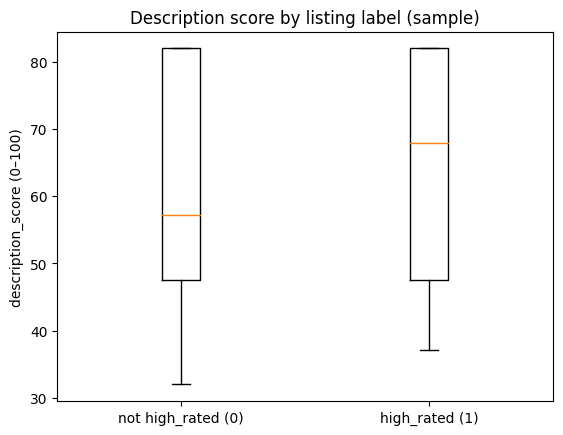

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

desc_pdf = (data_sample
    .select(
        F.col("high_rated").cast("int").alias("high_rated"),
        F.col("description_score").cast("double").alias("description_score")
    )
    .where(F.col("description_score").isNotNull())
    .toPandas()
)

g0 = desc_pdf.loc[desc_pdf["high_rated"] == 0, "description_score"].dropna()
g1 = desc_pdf.loc[desc_pdf["high_rated"] == 1, "description_score"].dropna()

plt.figure()
plt.boxplot([g0, g1], labels=["not high_rated (0)", "high_rated (1)"])
plt.title("Description score by listing label (sample)")
plt.ylabel("description_score (0–100)")
plt.show()

Model coefficients table (interpretable appendix table)- plotted from data sample not the full output dataset

Intercept = -8.369675468795851


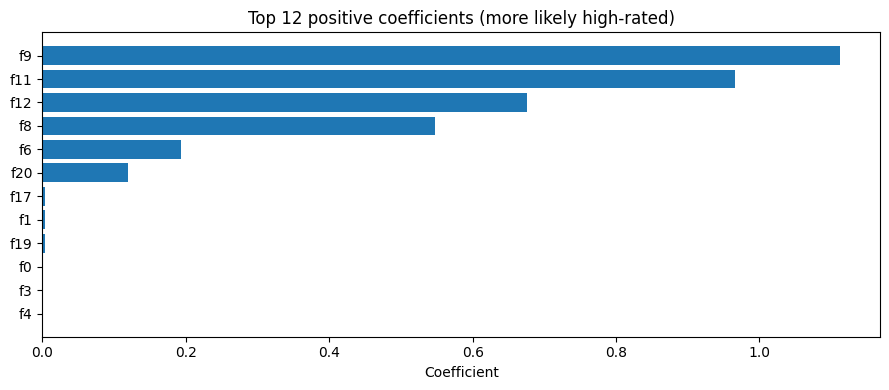

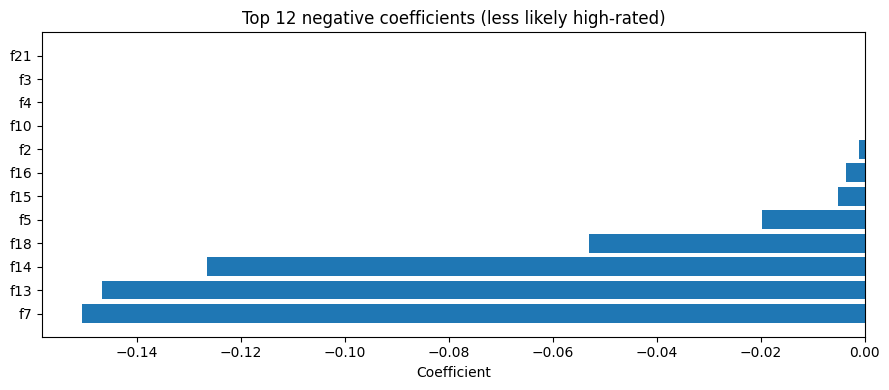

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:468)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1) Pull LR model + coefficients
# -----------------------------
lr_model = model.stages[-1]   # LogisticRegression stage
coefs = lr_model.coefficients.toArray()
intercept = lr_model.intercept
print("Intercept =", intercept)

# -----------------------------
# 2) Find stages
# -----------------------------
assembler_stage = None
ohe_stage = None
indexer_stage = None

for st in model.stages:
    name = st.__class__.__name__
    if name == "VectorAssembler":
        assembler_stage = st
    elif name == "OneHotEncoderModel":   # after fitting, it becomes OneHotEncoderModel
        ohe_stage = st
    elif name == "StringIndexerModel":
        indexer_stage = st

# Base feature names (non-country)
base_feats = assembler_stage.getInputCols() if assembler_stage else [f"f{i}" for i in range(len(coefs))]

# -----------------------------
# 3) Expand country_ohe into real dim names
# -----------------------------
feat_names = []
for f in base_feats:
    if f != "country_ohe":
        feat_names.append(f)
    else:
        # Try to get category labels from StringIndexerModel (best case)
        labels = None
        if indexer_stage is not None and hasattr(indexer_stage, "labels"):
            labels = list(indexer_stage.labels)

        # Determine how many OHE dims were produced (default: dropLast=True)
        # if labels exist: dims = len(labels)-1
        if labels is not None and len(labels) >= 2:
            dims = len(labels) - 1
            feat_names.extend([f"country_ohe={labels[i]}" for i in range(dims)])
        else:
            # fallback: unknown labels, still expand by matching remaining coef count later
            feat_names.append("country_ohe")  # temporary placeholder

# -----------------------------
# 4) If still mismatch, do a safe fallback to generic names
# -----------------------------
if len(feat_names) != len(coefs):
    feat_names = [f"f{i}" for i in range(len(coefs))]

# -----------------------------
# 5) Build coef table + plot
# -----------------------------
coef_pdf = pd.DataFrame({"feature": feat_names, "coef": coefs}).sort_values("coef", ascending=False)

TOP = 12
top_pos = coef_pdf.head(TOP).sort_values("coef", ascending=True)
top_neg = coef_pdf.tail(TOP).sort_values("coef", ascending=True)

plt.figure(figsize=(9, 4))
plt.barh(top_pos["feature"], top_pos["coef"])
plt.title(f"Top {TOP} positive coefficients (more likely high-rated)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title(f"Top {TOP} negative coefficients (less likely high-rated)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


In [0]:
# =========================
# Map f0,f1,f2,...  -> real feature names
# Works even when OneHotEncoder expands country into multiple dims.
# =========================

# 1) Find stages
assembler_stage = next(st for st in model.stages if st.__class__.__name__ == "VectorAssembler")
ohe_stage       = next(st for st in model.stages if st.__class__.__name__ == "OneHotEncoderModel")
indexer_stage   = next(st for st in model.stages if st.__class__.__name__ == "StringIndexerModel")

base_input_cols = assembler_stage.getInputCols()   # this includes "country_ohe" as one entry

# 2) How many dims does country_ohe expand to?
# (Spark stores this in the metadata of the transformed column)
tmp = model.transform(train_df).select("country_ohe").limit(1)
ohe_meta = tmp.schema["country_ohe"].metadata

# Try to read number of binary attributes (works for most Spark versions)
ohe_dims = None
if "ml_attr" in ohe_meta and "attrs" in ohe_meta["ml_attr"]:
    attrs = ohe_meta["ml_attr"]["attrs"]
    # attrs can have "binary" or "numeric"
    if "binary" in attrs:
        ohe_dims = len(attrs["binary"])
    elif "numeric" in attrs:
        ohe_dims = len(attrs["numeric"])

# Fallback: infer by vector length if metadata isn't available
if ohe_dims is None:
    ohe_dims = tmp.first()["country_ohe"].size

# 3) Build expanded names list
expanded_names = []
for c in base_input_cols:
    if c != "country_ohe":
        expanded_names.append(c)
    else:
        # label names for country dummies (order is based on StringIndexer labels)
        country_labels = indexer_stage.labels  # e.g. ["France","Italy","Germany"] (order learned)
        # OneHotEncoder drops the last category by default, so dims = len(labels)-1
        for i in range(ohe_dims):
            lab = country_labels[i] if i < len(country_labels) else f"idx_{i}"
            expanded_names.append(f"country_ohe={lab}")

# 4) Print mapping
lr_model = model.stages[-1]
coefs = lr_model.coefficients.toArray()

print("Num coefs:", len(coefs))
print("Num names:", len(expanded_names))

for i, name in enumerate(expanded_names):
    print(f"f{i} -> {name}")

Num coefs: 22
Num names: 22
f0 -> word_count
f1 -> sentence_count
f2 -> avg_words_per_sentence
f3 -> has_sections
f4 -> has_bullets
f5 -> has_checkin_info
f6 -> punct_rate
f7 -> all_caps_rate
f8 -> is_supperhost
f9 -> is_guest_favorite
f10 -> host_number_of_reviews
f11 -> host_rating
f12 -> host_response_rate
f13 -> pets_allowed
f14 -> mentioned_any_landmark
f15 -> has_landmarks_within5
f16 -> centrality_score_sel
f17 -> landmarks_1km_sel
f18 -> country_ohe=France
f19 -> country_ohe=Italy
f20 -> country_ohe=Germany
f21 -> country_ohe=idx_3


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:468)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

ROC curve- from the fulll output dataset 


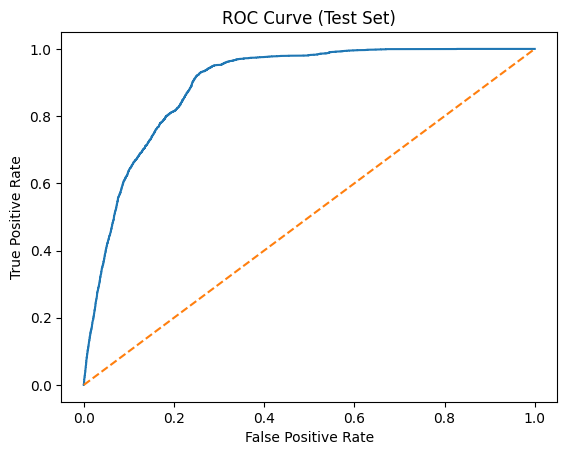

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:468)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

roc_pdf = (pred_test
    .select(
        F.col("high_rated").cast("int").alias("y"),
        vector_to_array("prob").getItem(1).alias("p1")
    )
    .toPandas()
)

y = roc_pdf["y"].values
p = roc_pdf["p1"].values

# ROC without sklearn
thresholds = np.unique(p)
thresholds = np.r_[1.0, thresholds[::-1], 0.0]

P = (y == 1).sum()
N = (y == 0).sum()

tpr, fpr = [], []
for t in thresholds:
    pred = (p >= t).astype(int)
    TP = ((pred == 1) & (y == 1)).sum()
    FP = ((pred == 1) & (y == 0)).sum()
    tpr.append(TP / P if P > 0 else 0.0)
    fpr.append(FP / N if N > 0 else 0.0)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


Centrality Score by Listing Label (data_sample)

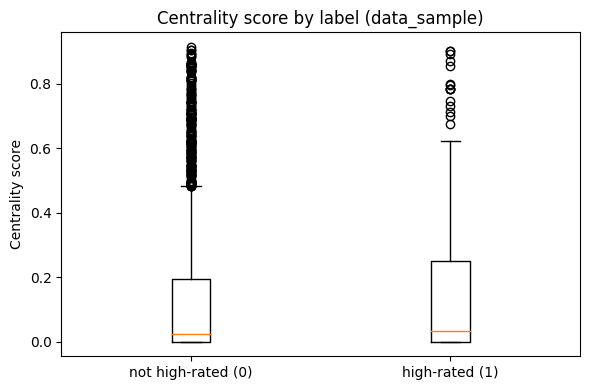

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

pdf = (data_sample
    .select(F.col("high_rated").cast("int").alias("high_rated"),
            F.col("centrality_score_sel").cast("double").alias("centrality"))
    .fillna({"centrality": 0.0})
    .toPandas()
)

c0 = pdf[pdf["high_rated"]==0]["centrality"].dropna()
c1 = pdf[pdf["high_rated"]==1]["centrality"].dropna()

plt.figure(figsize=(6,4))
plt.boxplot([c0, c1], labels=["not high-rated (0)", "high-rated (1)"])
plt.title("Centrality score by label (data_sample)")
plt.ylabel("Centrality score")
plt.tight_layout()
plt.show()
